In [1]:
import gzip
import scipy
import scipy.optimize
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def readJSON(path):
    for l in gzip.open(path, 'rt', encoding='UTF-8'):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u, g, d

## Question 1 (Baseline)

In [3]:
#Splitting into training and validation sets
raw_data = []
for user, game, d in readJSON("train.json.gz"):
    raw_data.append([user, game, d])
    
train = raw_data[:165000]
raw_valid = raw_data[165000:]

In [4]:
#Creating a dict with user as key and all games played by him as values
gamesOfUser = defaultdict(set)
for item in raw_data:
    gamesOfUser[item[0]].add(item[1])

#Creating a set with all the games
allGames = set()
for item in raw_data:
    allGames.add(item[1])

In [5]:
#Modifying validation set
valid = []
for item in raw_valid:
    tup = (item[0], item[1], 1)
    valid.append(tup)

#Creating a negative validation elements and appending to validation set (valid)
for item in raw_valid:
    user = item[0]
    games = gamesOfUser[user]
    notPlayedGames = allGames - games
    randomOne = random.sample(notPlayedGames, 1)[0]
    tup = (user, randomOne, 0)
    valid.append(tup)    

In [6]:
### Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked

gameCount = defaultdict(int)
totalPlayed = 0

for user, game, _ in train:
    gameCount[game] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort(reverse = True)

In [7]:
return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/2: break

predictions = []

for l in valid:
    u, g, _ = l[0], l[1], l[2]
    if g in return1:
        predictions.append(1)
    else:
        predictions.append(0)

actualValues = []
for item in valid:
    actualValues.append(item[2])
    

correctValues = [a == b for a, b in zip(predictions, actualValues)]

print('Validation Accuracy: ' + str(sum(correctValues)/len(valid)*100))

Validation Accuracy: 68.10000000000001


## Question 2 (Popularity)

In [8]:
return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    #Taking 68.9% of the top values (1/1.45)
    if count > totalPlayed/1.45: break

predictions = []

for l in valid:
    u, g, _ = l[0], l[1], l[2]
    if g in return1:
        predictions.append(1)
    else:
        predictions.append(0)

actualValues = []
for item in valid:
    actualValues.append(item[2])
    

correctValues = [a == b for a, b in zip(predictions, actualValues)]

print('Validation Accuracy: ' + str(sum(correctValues)/len(valid)*100))

Validation Accuracy: 70.27


## Question 3 (Jaccard)

In [9]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [10]:
#Creating 2 dicts. One with game and one with user

gamesOfUser = defaultdict(set)
usersOfGame = defaultdict(set)

#Only on training set
for item in train:
    gamesOfUser[item[0]].add(item[1])
    usersOfGame[item[1]].add(item[0])

In [11]:
def mostSimilar(u, g):
    similarities = []
    users = usersOfGame[g]
    for g2 in gamesOfUser[u]:
        if g == g2: continue # other than the query
        sim = Jaccard(users, usersOfGame[g2])
        similarities.append(sim)
    
    count = 0
    #Thershold set as 0.008
    threshold = 0.008
    for sim in similarities:
        if sim > threshold:
            count += 1
    
    #Since it is given most of the values should cross. Assuming it to be more than 50%.
    #Can be done using median too
    if count > 0.5*len(similarities):
        return 1
    return 0

In [12]:
out = 0

predictions = []
for item in valid:
    predictions.append(mostSimilar(item[0], item[1]))
    
actualValues = []
for item in valid:
    actualValues.append(item[2])    

correctValues = [a == b for a, b in zip(predictions, actualValues)]

print('Validation Accuracy: ' + str(sum(correctValues)/len(valid)*100))

Validation Accuracy: 70.675


## Question 4 (Both Jaccard and Popularity)

In [13]:
out = 0

predictions = []
for item in valid:
    #Only checking Jaccard if it is popular in the first place
    if item[1] in return1:
        predictions.append(mostSimilar(item[0], item[1]))
    else:
        predictions.append(0)
    
actualValues = []
for item in valid:
    actualValues.append(item[2])    

correctValues = [a == b for a, b in zip(predictions, actualValues)]

print('Validation Accuracy: ' + str(sum(correctValues)/len(valid)*100))

Validation Accuracy: 70.78


## Question 5 (Test Set and Submitting to Kaggle)

In [14]:
f = open('pairs_Played.txt', 'r')
lines = f.readlines()
f.close()

f = open('pairs_Played_Final.txt', 'w')
f.write('userID-gameID,prediction\n')
lines = lines[1:]
for line in lines:
    u, g = line.strip().split('-')
    if g in return1:
        res = mostSimilar(u, g)
    else:
        res = 0
    f.write(u + '-' + g + ',' + str(res) + '\n')

f.close()

In [15]:
print('Submitted to Kaggle')
print('\nKaggle Username: aditya1c')

Submitted to Kaggle

Kaggle Username: aditya1c


## Question 9

In [16]:
import gzip
import scipy
import scipy.optimize
import random
import numpy as np
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [17]:
def readJSON1(path):
    for l in gzip.open(path, 'rt', encoding='UTF-8'):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u, g, d

In [18]:
#Splitting into training and validation sets
dataset = []
for user, game, d in readJSON1("train.json.gz"):
    dataset.append([user, game, d['hours_transformed']])
    
train = dataset[:165000]
valid = dataset[165000:]

In [19]:
hoursPerUser = defaultdict(list) 
hoursPerGame = defaultdict(list)
allHours = []

for user, game, h in train:
    allHours.append(h)
    #These variables are not used much. Just to maintain consistency with workbook code
    hoursPerUser[user].append(h)
    hoursPerGame[game].append(h)

In [20]:
N = len(dataset)
nUsers = len(hoursPerUser)
nGames = len(hoursPerGame)
users = list(hoursPerUser.keys())
games = list(hoursPerGame.keys())

In [21]:
alpha = sum(allHours)/len(allHours)
userBiases = defaultdict(float)
gameBiases = defaultdict(float)

Defining Functions which are similar to those discussed in the class

In [22]:
def prediction(user, game):
    return alpha + userBiases[user] + gameBiases[game]

In [23]:
def unpack(theta):
    global alpha
    global userBiases
    global gameBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    gameBiases = dict(zip(games, theta[1+nUsers:]))

In [24]:
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(u, g) for u, g, h in dataset]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in gameBiases:
        cost += lamb*gameBiases[i]**2
    return cost

In [25]:
def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dGameBiases = defaultdict(float)
    for u, g, h in dataset:
        u,i = u, g
        pred = prediction(u, i)
        diff = pred - h
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dGameBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in gameBiases:
        dGameBiases[i] += 2*lamb*gameBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dGameBiases[i] for i in games]
    return np.array(dtheta)

In [26]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

Training on training set with lambda = 1

In [27]:
scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nGames),
                             derivative, args = (allHours, 1))

MSE = 5.278092701060167
MSE = 5.16120582374076
MSE = 5.270689759068286
MSE = 5.270671151591758


(array([ 3.71692873e+00, -3.78401687e-04,  9.83975786e-05, ...,
        -5.99324950e-05, -1.48154596e-04, -1.97093987e-04]),
 5.274386908456481,
 {'grad': array([ 4.38829221e-06, -7.04861889e-07, -1.01770037e-07, ...,
         -1.59076999e-07, -2.26936299e-07, -1.85819517e-07]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 4,
  'nit': 2,
  'warnflag': 0})

Testing on Validation Set

In [28]:
allHoursValid = []
for u, g, h in valid:
    allHoursValid.append(h)

In [29]:
#This is to use if user or game are not found in test set
ratingMean = sum(allHoursValid)/len(allHoursValid)
ratingMean

3.7470679897714194

In [30]:
predictionsValid = []
for u, g, h in valid:
    predictionsValid.append(prediction(u, g))

In [31]:
mseValid = MSE(predictionsValid, allHoursValid)
print('MSE on Validation Set with lambda as 1 is ' + str(mseValid))

MSE on Validation Set with lambda as 1 is 5.307731893929159


## Question 10

In [32]:
#Sorting using lambda and key
sorted_users = sorted(userBiases.items(), key = lambda x: x[1])
smallestUser = sorted_users[0]
largestUser = sorted_users[-1]

In [33]:
sorted_games = sorted(gameBiases.items(), key = lambda x: x[1])
smallestGame = sorted_games[0]
largestGame = sorted_games[-1]

In [34]:
print('Smallest User Bias: ' + str(smallestUser))
print('\nLargest User Bias: ' + str(largestUser))

Smallest User Bias: ('u79882368', -0.0016907822665307632)

Largest User Bias: ('u96523007', 0.002281539286103845)


In [35]:
print('Smallest Game Bias: ' + str(smallestGame))
print('\nLargest Game Bias: ' + str(largestGame))

Smallest Game Bias: ('b26498441', -0.006233011558756534)

Largest Game Bias: ('b99449444', 0.024834582824163776)


## Question 11

Testing for lambda from 0 to 1 in steps of 0.05

In [ ]:
bestLambda = 0
bestMSE = float('inf')
lambdaList = []
mseList = []

lamb = 0
step = 0.05
#Training and checking using Lambda from 0 to 1
for i in range(int(1/step) + 1):
    tmpLamb = lamb + 0.05*i
    scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nGames),
                             derivative, args = (allHours, tmpLamb), disp = False)
    predictionsValid = []
    for u, g, h in valid:
        predictionsValid.append(prediction(u, g))
    mseValid = MSE(predictionsValid, allHoursValid)
    lambdaList.append(tmpLamb)
    mseList.append(mseValid)
    if mseValid < bestMSE:
        bestMSE = mseValid
        bestLambda = tmpLamb

The above code block output is run locally but not showed it here as the output is too long

In [37]:
print('Best Lambda: ' + str(bestLambda))
print('Best MSE: ' + str(bestMSE))

Best Lambda: 0.0
Best MSE: 2.7231671446334045


Text(0.5, 1.0, 'Variation of MSE with Lambda')

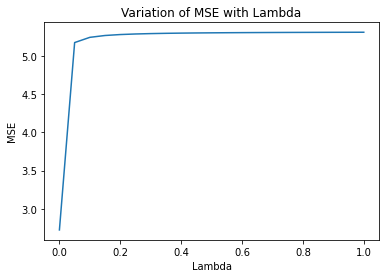

In [38]:
plt.plot(lambdaList, mseList)
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('Variation of MSE with Lambda')

Best Model is used to predict the test set and uploaded to Kaggle

In [39]:
f = open('pairs_Hours.txt', 'r')
lines = f.readlines()
f.close()

f = open('pairs_Hours_Final.txt', 'w')
f.write('userID-gameID,prediction\n')
lines = lines[1:]
for line in lines:
    u, g = line.strip().split('-')
    res = prediction(u, g)
    #This can be replaced with 0 if required too. Just used for checking in Kaggle
    if u not in userBiases or g not in gameBiases:
        res = ratingMean
        
    f.write(u + '-' + g + ',' + str(res) + '\n')

f.close()

In [40]:
print('Submitted to Kaggle')
print('\nKaggle Username: aditya1c')

Submitted to Kaggle

Kaggle Username: aditya1c
